In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("./data.csv")

In [3]:
sample_sub = pd.read_csv("./sample_submission.csv")

In [4]:
df.shape, sample_sub.shape

((30697, 28), (5000, 2))

In [5]:
df.columns

Index(['Unnamed: 0', 'match_event_id', 'location_x', 'location_y',
       'remaining_min', 'power_of_shot', 'knockout_match', 'game_season',
       'remaining_sec', 'distance_of_shot', 'is_goal', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'team_name', 'date_of_game',
       'home/away', 'shot_id_number', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot', 'match_id', 'team_id', 'remaining_min.1',
       'power_of_shot.1', 'knockout_match.1', 'remaining_sec.1',
       'distance_of_shot.1'],
      dtype='object')

In [6]:
df.head()

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,...,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,...,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,...,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,...,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,...,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,...,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [7]:
shot_id_mask = df['shot_id_number'].isnull()
df.loc[shot_id_mask, 'shot_id_number'] =  df.loc[shot_id_mask].index + 1
df['shot_id_number'] = df['shot_id_number'].astype('int')

In [8]:
df['date_of_game'] = df['date_of_game'].fillna(method='ffill')
df['date_of_game'] = pd.to_datetime(df['date_of_game'])

df['game_season'] = df['game_season'].fillna(method='ffill')

In [9]:
sample_ids = set(sample_sub.shot_id_number)

In [10]:
df['is_train'] = df['shot_id_number'].apply(lambda x: x not in sample_ids)

In [11]:
df.is_train.value_counts()

True     25697
False     5000
Name: is_train, dtype: int64

In [12]:
def create_agg_features(features, agg_on_col):
    for col in features:
        tmp = df.groupby([agg_on_col]).agg({col:['min','mean','max','std']})
        tmp.columns = tmp.columns.droplevel()
        tmp_min = tmp['min'].to_dict()
        tmp_max = tmp['max'].to_dict()
        tmp_mean = tmp['mean'].to_dict()
        tmp_std = tmp['std'].to_dict()
        
        df[agg_on_col+"_"+col+"_"+'min'] = df[agg_on_col].map(tmp_min)
        df[agg_on_col+"_"+col+"_"+'max'] = df[agg_on_col].map(tmp_max)
        df[agg_on_col+"_"+col+"_"+'mean'] = df[agg_on_col].map(tmp_mean)
        df[agg_on_col+"_"+col+"_"+'std'] = df[agg_on_col].map(tmp_std)
        

In [13]:
agg_features = ['remaining_min', 
 'power_of_shot', 
 'remaining_sec', 
 'distance_of_shot',
 'remaining_min.1', 
 'power_of_shot.1', 
 'remaining_sec.1', 
 'distance_of_shot.1',
]

#create_agg_features(agg_features, 'match_id')
#create_agg_features(agg_features, 'game_season')
# create_agg_features(agg_features, 'match_event_id')


In [14]:
df[df.is_train==False].shape

(5000, 29)

In [15]:
train = df[df.is_train]
test = df[~df.is_train]

In [16]:
def draw_distribution(feature):
    
    plt.figure(figsize=(15,7))
    
    if train[feature].dtype == 'object':
        sns.countplot(x=feature, data=df, hue='is_train')
        #sns.countplot(train[feature].dropna())
        #sns.countplot(test[feature].dropna())
    else:    
        sns.distplot(train[feature].dropna())
        sns.distplot(test[feature].dropna())


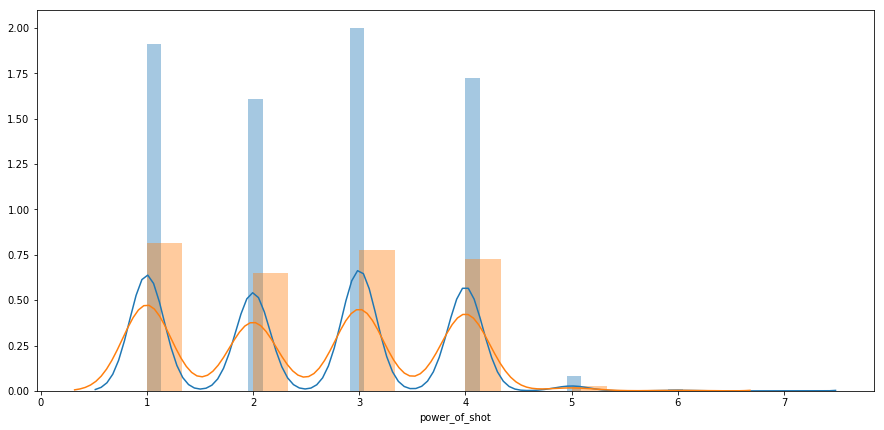

In [17]:
draw_distribution('power_of_shot')

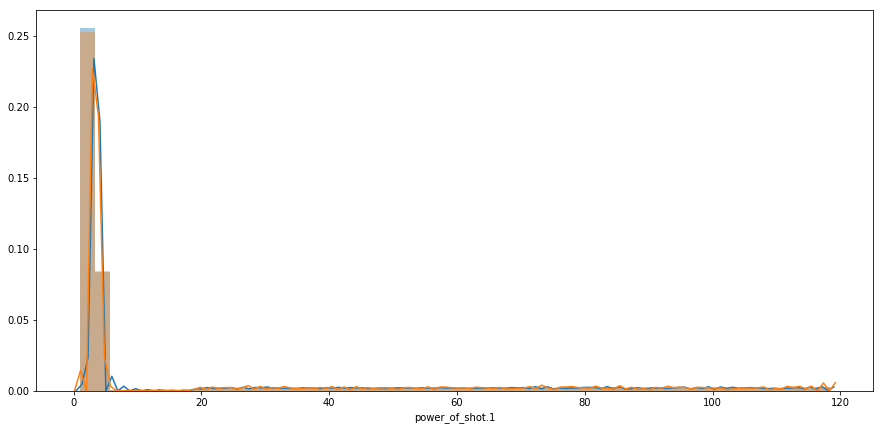

In [18]:
draw_distribution('power_of_shot.1')

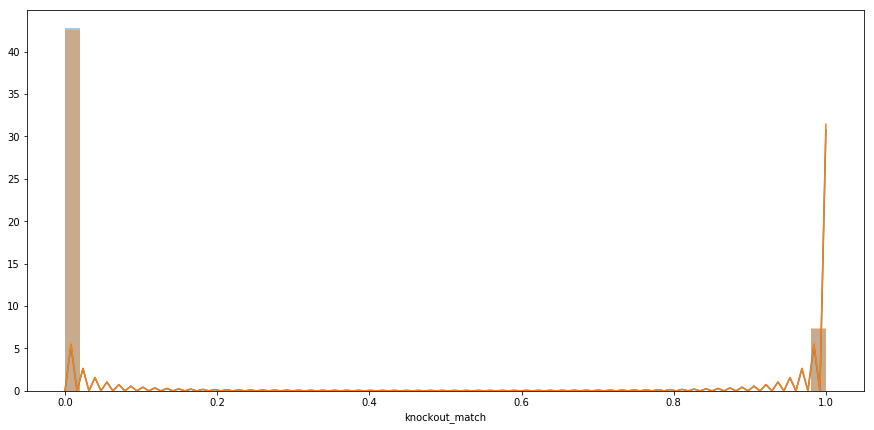

In [19]:
draw_distribution('knockout_match')

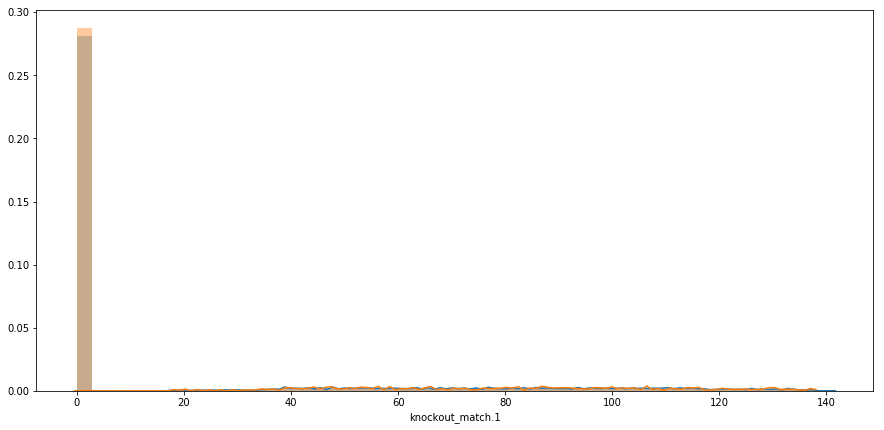

In [20]:
draw_distribution('knockout_match.1')

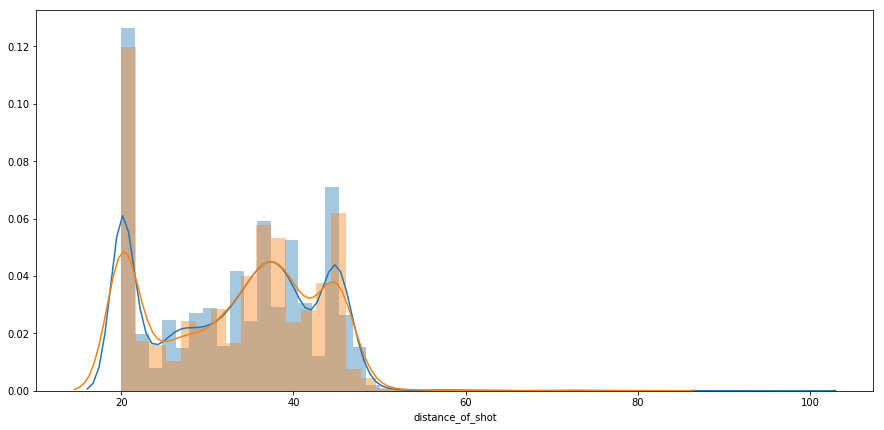

In [21]:
draw_distribution('distance_of_shot')

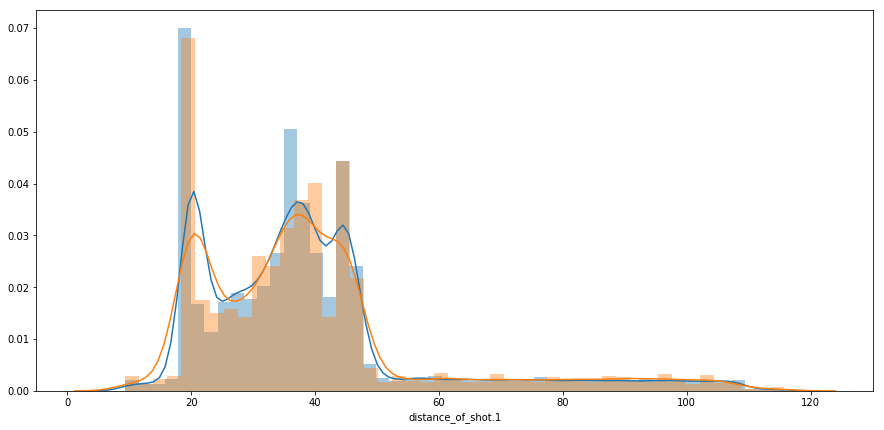

In [22]:
draw_distribution('distance_of_shot.1')

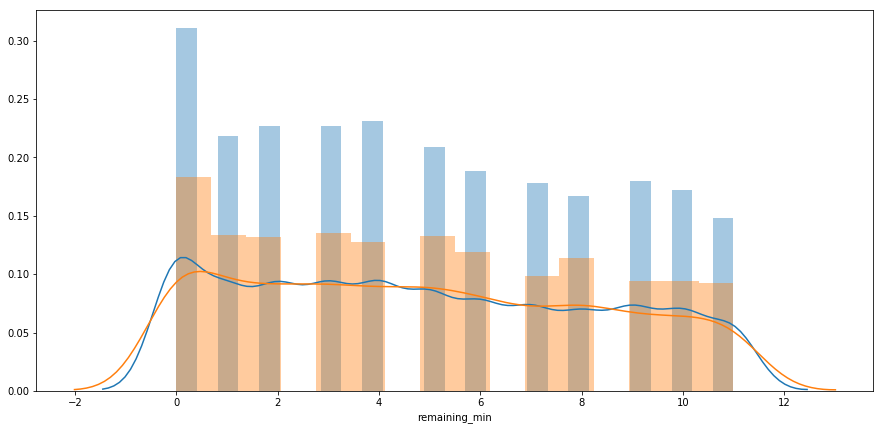

In [23]:
draw_distribution('remaining_min')

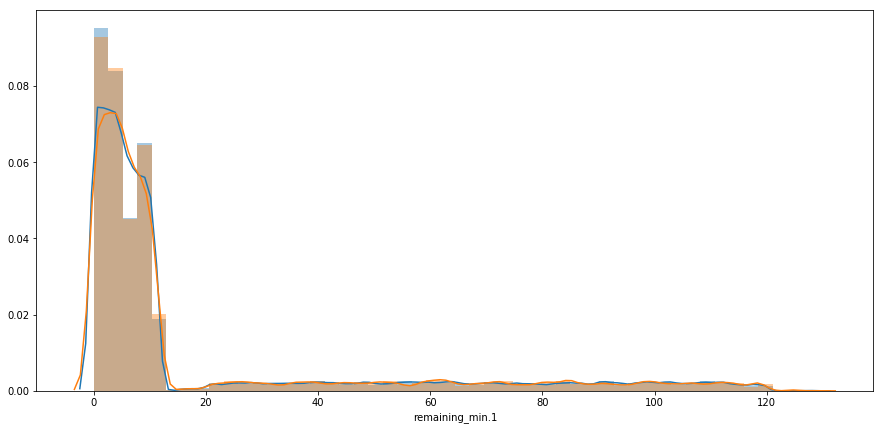

In [24]:
draw_distribution('remaining_min.1')

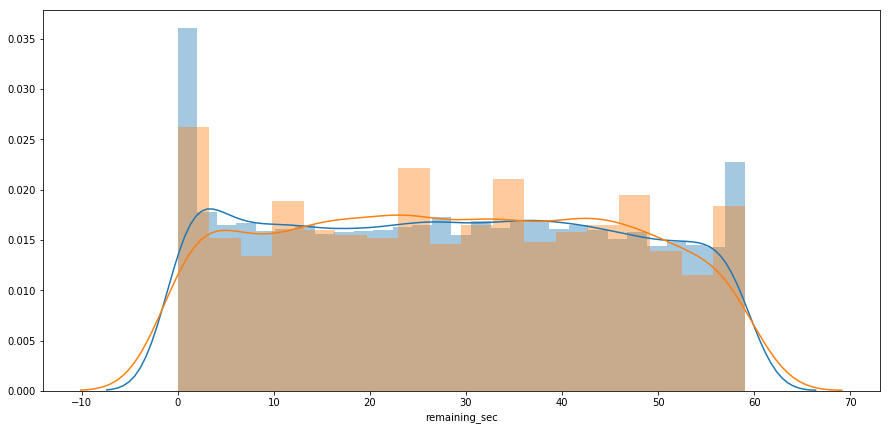

In [25]:
draw_distribution('remaining_sec')

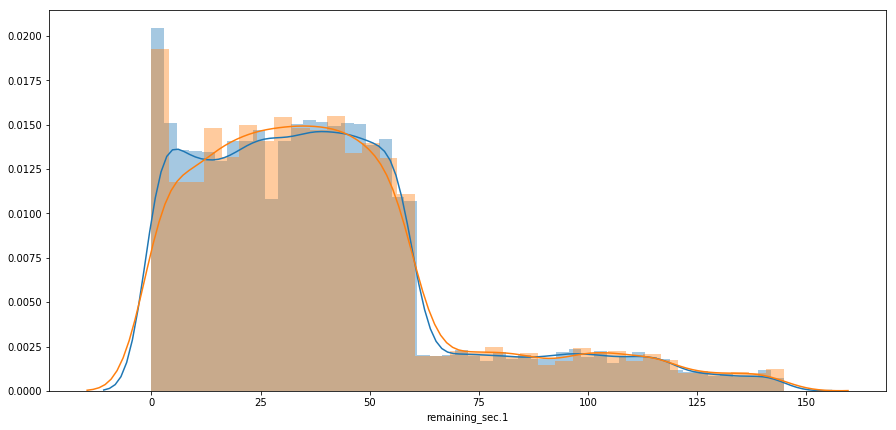

In [26]:
draw_distribution('remaining_sec.1')

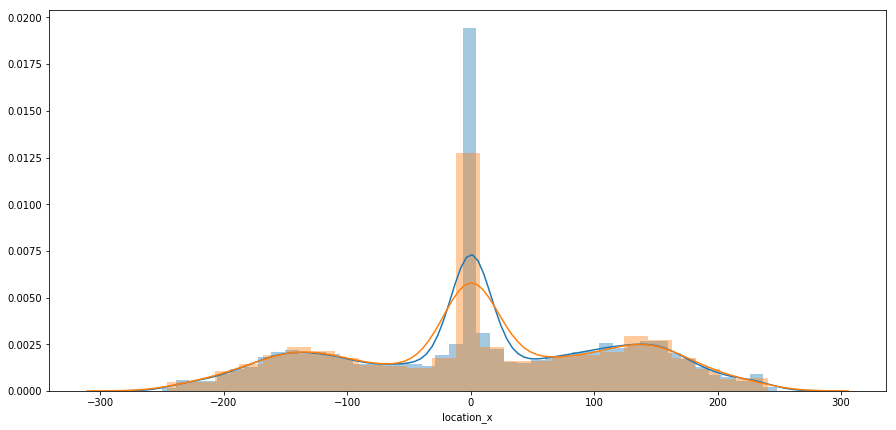

In [27]:
draw_distribution('location_x')

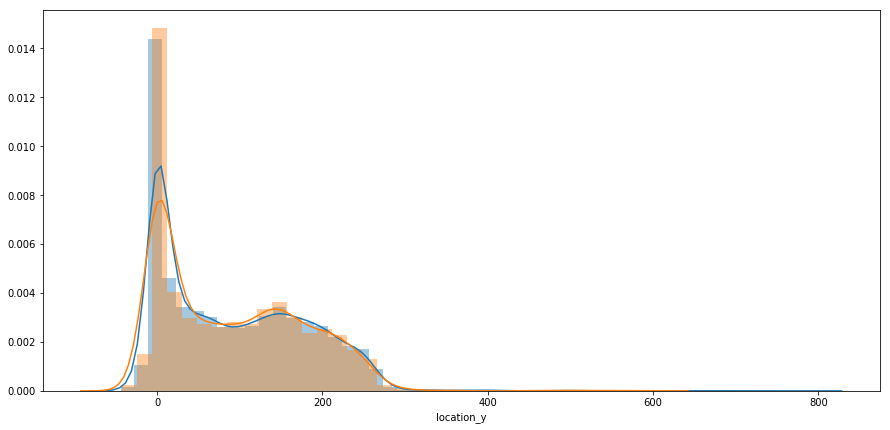

In [28]:
draw_distribution('location_y')

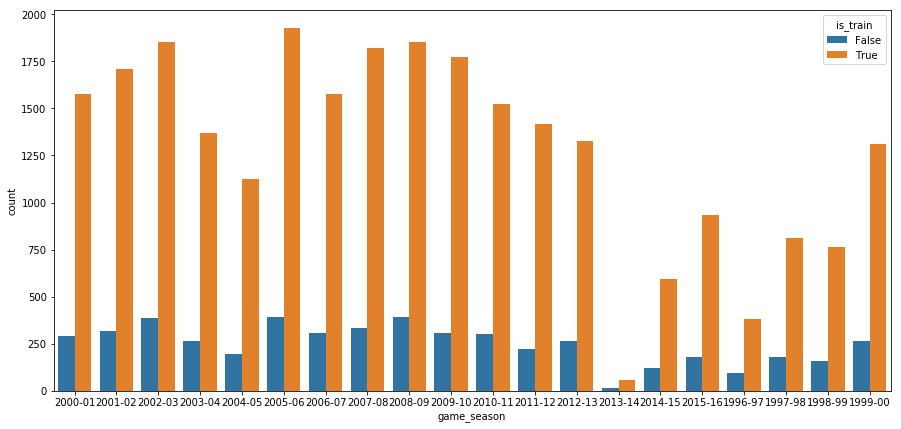

In [29]:
draw_distribution('game_season')

In [30]:
cat_var = ['area_of_shot',
       'shot_basics', 'range_of_shot', 'team_name',
       'home/away', 'shot_id_number', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot']

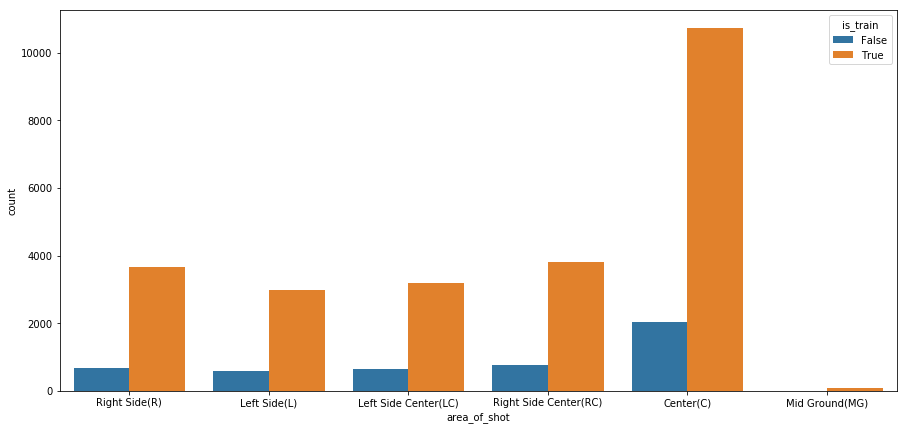

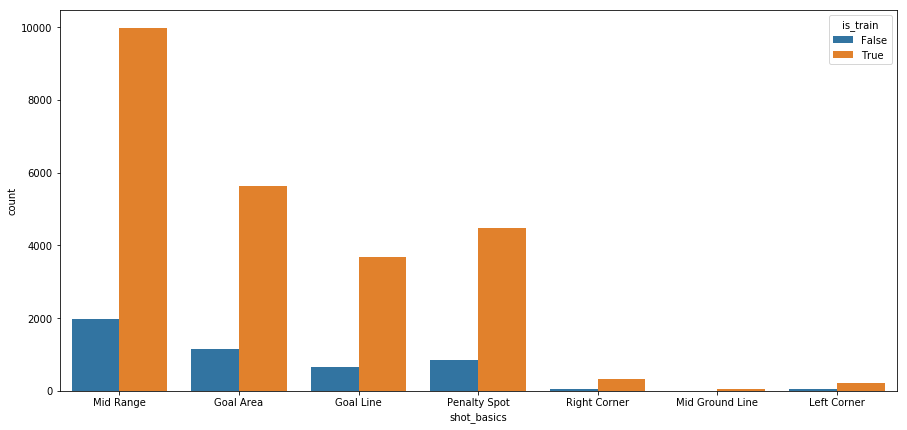

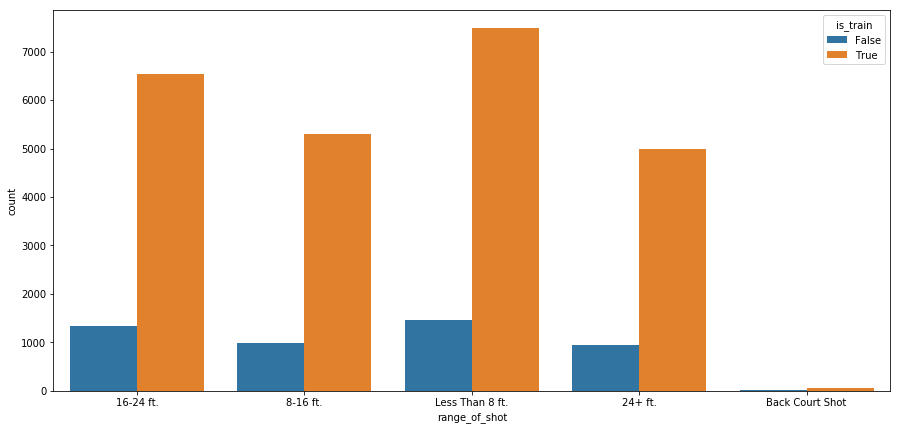

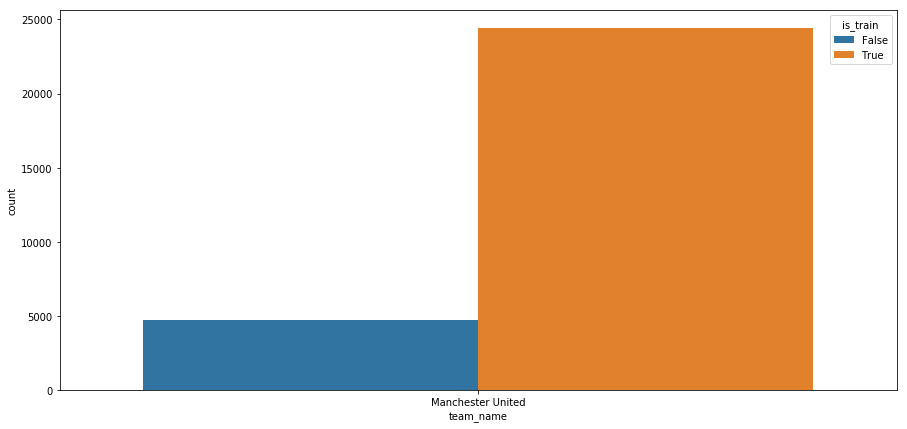

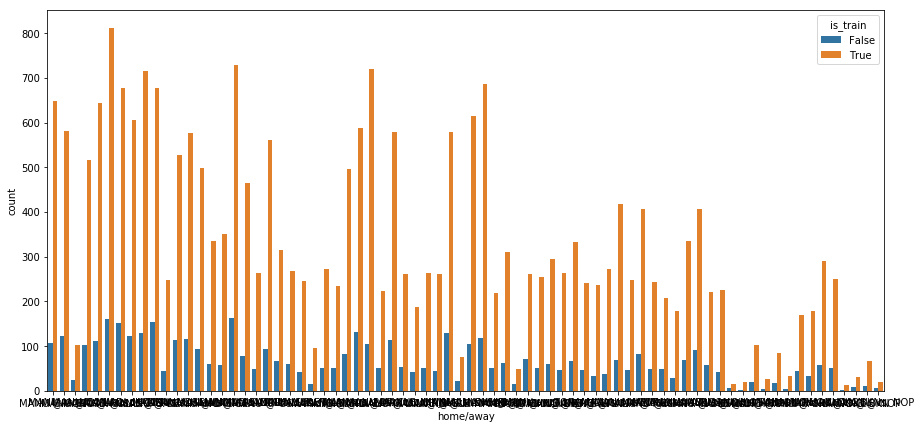

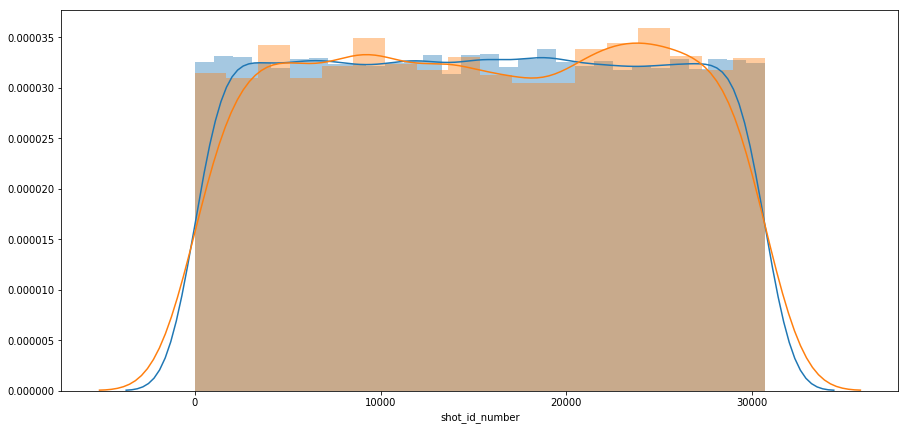

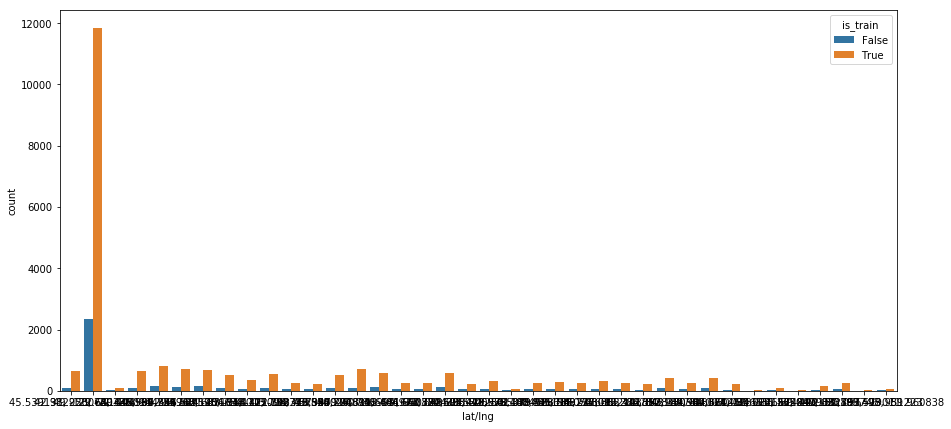

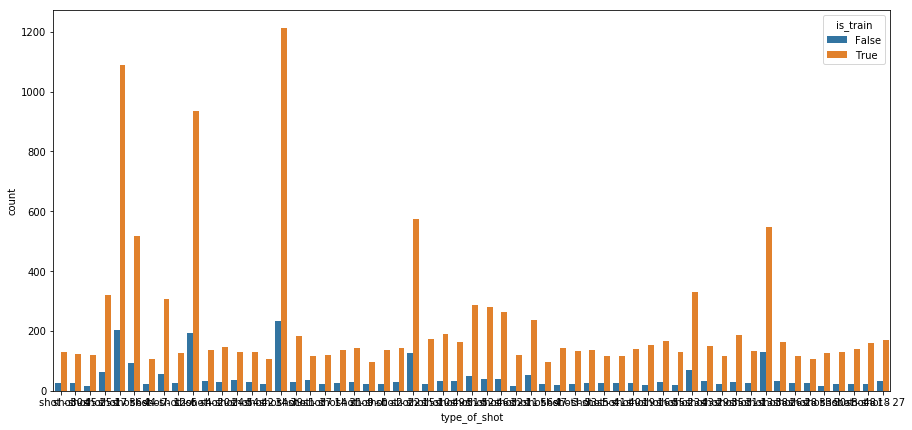

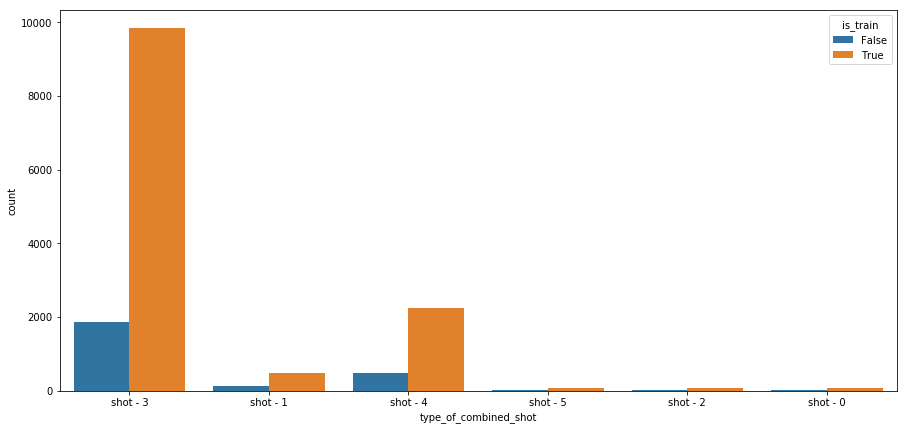

In [31]:
for col in cat_var:
    draw_distribution(col)

In [32]:
for col in train.select_dtypes('object').columns:
    print(col)
    _most_freq = train[col].mode()[0]
    print(_most_freq)
    train[col] = train[col].fillna(_most_freq)
    test[col] = test[col].fillna(_most_freq)
    

game_season
2005-06
area_of_shot
Center(C)


/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shot_basics
Mid Range
range_of_shot
Less Than 8 ft.
team_name
Manchester United
home/away
MANU @ SAS
lat/lng
42.982923, -71.446094
type_of_shot
shot - 39
type_of_combined_shot
shot - 3


In [33]:
for col in train.select_dtypes('float').columns:
    print(col)
    _most_freq = train[col].mode()[0]
    print(_most_freq)
    train[col] = train[col].fillna(_most_freq)
    test[col] = test[col].fillna(_most_freq)

match_event_id
2.0
location_x
0.0


/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


location_y
0.0
remaining_min
0.0
power_of_shot
3.0
knockout_match
0.0
remaining_sec
0.0
distance_of_shot
20.0
is_goal
0.0
remaining_min.1
0.0
power_of_shot.1
3.0
knockout_match.1
0.0
remaining_sec.1
0.0
distance_of_shot.1
20.0


In [34]:
for col in train.select_dtypes('object').columns:
    print(col)
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    

game_season
area_of_shot


/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shot_basics
range_of_shot
team_name
home/away
lat/lng
type_of_shot
type_of_combined_shot


In [35]:
# plt.figure(figsize=(15,15))
# sns.heatmap(train.corr(), annot=True, cmap="YlGnBu")

In [36]:
from sklearn.feature_selection import chi2

In [39]:
chi2(train[['power_of_shot','type_of_shot']],train['is_goal'].reshape(-1,1))

/home/shobhit/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


(array([13.33266503,  4.1193035 ]), array([0.00026082, 0.04239653]))

In [36]:
train.columns

Index(['Unnamed: 0', 'match_event_id', 'location_x', 'location_y',
       'remaining_min', 'power_of_shot', 'knockout_match', 'game_season',
       'remaining_sec', 'distance_of_shot', 'is_goal', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'team_name', 'date_of_game',
       'home/away', 'shot_id_number', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot', 'match_id', 'team_id', 'remaining_min.1',
       'power_of_shot.1', 'knockout_match.1', 'remaining_sec.1',
       'distance_of_shot.1', 'is_train'],
      dtype='object')

In [96]:
train = train[~train.is_goal.isnull()]

In [100]:
selected_features = ['location_y', 'distance_of_shot','power_of_shot','type_of_shot', 'type_of_combined_shot']
selected_features = ['match_event_id', 'location_x', 'location_y',
       'remaining_min', 'power_of_shot', 'knockout_match', 
                     'game_season',
       'remaining_sec', 'distance_of_shot', 
                     'area_of_shot',
       'shot_basics', 'range_of_shot',
       'home/away', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot', 'match_id',
                    # 'remaining_min.1',
       #'power_of_shot.1', 'knockout_match.1', 'remaining_sec.1',
       #'distance_of_shot.1'
                    ]
X = train[selected_features]
y = train.is_goal

In [101]:
#X.drop(['is_goal'], axis=1, inplace=True)

In [102]:
#dummy.groupby(['match_id'])['is_goal'].mean()

In [103]:
X.isnull().sum()

match_event_id           0
location_x               0
location_y               0
remaining_min            0
power_of_shot            0
knockout_match           0
game_season              0
remaining_sec            0
distance_of_shot         0
area_of_shot             0
shot_basics              0
range_of_shot            0
home/away                0
lat/lng                  0
type_of_shot             0
type_of_combined_shot    0
match_id                 0
dtype: int64

In [104]:
train.is_goal.isnull().sum()

0

In [105]:
#train[['location_y','distance_of_shot','is_goal']].head(20)

In [106]:
test_df = test[selected_features]
#test_df.drop(['is_goal','date_of_game', 'Unnamed: 0','shot_id_number', 'team_name','team_id'], axis=1, inplace=True)
test_df.columns

Index(['match_event_id', 'location_x', 'location_y', 'remaining_min',
       'power_of_shot', 'knockout_match', 'game_season', 'remaining_sec',
       'distance_of_shot', 'area_of_shot', 'shot_basics', 'range_of_shot',
       'home/away', 'lat/lng', 'type_of_shot', 'type_of_combined_shot',
       'match_id'],
      dtype='object')

In [107]:
from sklearn.preprocessing import PolynomialFeatures

In [108]:
_num = ['location_x', 'location_y', 'remaining_min','power_of_shot' , 'remaining_sec', 'distance_of_shot']

In [109]:
poly = PolynomialFeatures(degree=3)
poly.fit(X[_num])

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)

In [110]:
X_poly = pd.DataFrame(poly.transform(X[_num]), columns=poly.get_feature_names(), index=X.index)

In [111]:
X_poly_test = pd.DataFrame(poly.transform(test_df[_num]), columns=poly.get_feature_names(), index=test_df.index)

In [112]:
X_final = pd.concat([X,X_poly], axis=1)
XTest_final = pd.concat([test_df,X_poly_test], axis=1)


In [113]:
X.shape, X_poly.shape, y.shape, X_final.shape

((25697, 17), (25697, 84), (25697,), (25697, 101))

In [114]:
X_final.shape, XTest_final.shape, y.shape

((25697, 101), (5000, 101), (25697,))

In [115]:
X_train, X_valid ,y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
#X_train, X_valid ,y_train, y_valid = train_test_split(X_pca, y, test_size=0.3, random_state=1)


In [116]:
dummy = X_train.copy()
dummy['is_goal'] = y_train

In [117]:
# for col in [#'match_event_id', 
#             'location_x', 
#             'location_y',
#             'remaining_min',
#             'power_of_shot', 
#             'knockout_match', 
#             'remaining_sec',
#             'distance_of_shot', 
#             'area_of_shot', 
#             'shot_basics', 
#             'range_of_shot',
#             'home/away', 
#             'lat/lng', 
#             'type_of_shot', 
#             'type_of_combined_shot',
#            #'match_id'
#            ]:
#     tmp = dummy.groupby(['game_season',col])['is_goal'].sum().to_dict()
#     def foo(row):
#         key = (row['game_season'],row[col])
#         if key not in tmp.keys():
#             return 0.0
#         else:
#             return tmp[key]
        
#     X_train[col+"_tencode"] = X_train.apply(foo, axis=1)
#     X_valid[col+"_tencode"] = X_valid.apply(foo, axis=1)
#     test_df[col+"_tencode"] = test_df.apply(foo, axis=1)
    


In [118]:
X_train.columns

Index(['match_event_id', 'location_x', 'location_y', 'remaining_min',
       'power_of_shot', 'knockout_match', 'game_season', 'remaining_sec',
       'distance_of_shot', 'area_of_shot', 'shot_basics', 'range_of_shot',
       'home/away', 'lat/lng', 'type_of_shot', 'type_of_combined_shot',
       'match_id'],
      dtype='object')

In [119]:
X.shape

(25697, 17)

In [120]:
top_features = ['location_x_tencode', 'location_y_tencode', 'type_of_combined_shot',
       'type_of_shot_tencode', 'type_of_combined_shot_tencode', 'shot_basics',
       'power_of_shot.1_min', 'remaining_sec_tencode', 'type_of_shot',
       'home/away_tencode', 'power_of_shot_max', 'remaining_min.1_min',
       'remaining_min_max', 'shot_basics_tencode', 'range_of_shot_tencode',
       'remaining_min_min', 'distance_of_shot_mean', 'knockout_match_tencode',
       'area_of_shot', 'lat/lng', 'game_season', 'location_y',
       'distance_of_shot.1_min', 'distance_of_shot.1_std',
       'power_of_shot_mean', 'power_of_shot', 'distance_of_shot_std',
       'power_of_shot.1_std', 'home/away', 'distance_of_shot.1_mean']

In [121]:
dtrain = xgb.DMatrix(X_train[:], label=y_train)
dvalid = xgb.DMatrix(X_valid[:], label=y_valid)


dtest = xgb.DMatrix(test_df[:])

In [122]:
param = {}
param['objective'] = 'binary:logistic' 
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = ['mae']
param['seed'] = 1
param['subsample'] = 1

evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    
num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-mae:0.49479	eval-mae:0.495551
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[50]	train-mae:0.430359	eval-mae:0.452303
[100]	train-mae:0.410016	eval-mae:0.449419
[150]	train-mae:0.392934	eval-mae:0.448212
[200]	train-mae:0.375302	eval-mae:0.44714
[250]	train-mae:0.362144	eval-mae:0.446276
[300]	train-mae:0.347075	eval-mae:0.445238
[350]	train-mae:0.332815	eval-mae:0.44447
[400]	train-mae:0.322325	eval-mae:0.444143
[450]	train-mae:0.30998	eval-mae:0.442941
[500]	train-mae:0.298008	eval-mae:0.441989
[550]	train-mae:0.286806	eval-mae:0.44182
[600]	train-mae:0.276063	eval-mae:0.441409
[650]	train-mae:0.267102	eval-mae:0.441112
[700]	train-mae:0.259489	eval-mae:0.440864
[750]	train-mae:0.251259	eval-mae:0.440337
[800]	train-mae:0.241616	eval-mae:0.439957
[850]	train-mae:0.233054	eval-mae:0.439309
[900]	train-mae:0.228226	eval-mae:0.438916
[950]	train-mae:0.226399	eval-mae:0.438874
[1000]	

In [123]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

In [124]:
1/(1+ mean_absolute_error(y_valid,y_pred))

0.6953498569892768

In [125]:
0.6953498569892768


0.6953498569892768

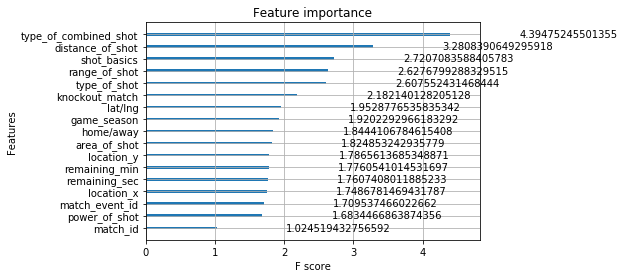

In [126]:
xgb.plot_importance(bst, importance_type='gain')

In [127]:
sorted(bst.get_score(importance_type='gain'), key=lambda x: x[1])[::-1]

['type_of_combined_shot',
 'type_of_shot',
 'area_of_shot',
 'home/away',
 'power_of_shot',
 'location_y',
 'location_x',
 'knockout_match',
 'distance_of_shot',
 'shot_basics',
 'remaining_min',
 'remaining_sec',
 'lat/lng',
 'game_season',
 'match_id',
 'match_event_id',
 'range_of_shot']

In [128]:
tt = bst.get_score(importance_type='gain')

In [129]:
top_f = pd.DataFrame(tt, index=range(1)).T

In [130]:
top_f.sort_values(by=[0], ascending=False).index[:30]

Index(['type_of_combined_shot', 'distance_of_shot', 'shot_basics',
       'range_of_shot', 'type_of_shot', 'knockout_match', 'lat/lng',
       'game_season', 'home/away', 'area_of_shot', 'location_y',
       'remaining_min', 'remaining_sec', 'location_x', 'match_event_id',
       'power_of_shot', 'match_id'],
      dtype='object')

In [131]:
#y = y.astype('int')

In [132]:
# import lightgbm as lgb

# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_valid, label=y_valid)


# param = {'num_leaves': 31, 'objective': 'binary'}
# param['metric'] = 'mae'


# num_round = 10000
# bst = lgb.train(param, train_data, num_round, valid_sets=[valid_data], early_stopping_rounds=50)

# ypred = bst.predict(X_valid, num_iteration=bst.best_iteration)

# 1/(1+ mean_absolute_error(y_valid,ypred))

# lgb.plot_importance(bst, importance_type='gain')

In [133]:
from sklearn.model_selection import StratifiedKFold


In [134]:
num_splits = 5
skf = StratifiedKFold(n_splits= num_splits, random_state=1, shuffle=True)

In [135]:
param = {}
param['objective'] = 'binary:logistic' 
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = ['mae']
param['seed'] = 1
param['subsample'] = 1

# evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    
# num_round = 10000
# bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=50)

In [136]:
y_test_pred = np.zeros((test_df.shape[0], 1))
print(y_test_pred.shape)
y_valid_scores = []

#X = df
fold_cnt = 1
for train_index, test_index in skf.split(X, y):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     dummy = X_train.copy()
#     dummy['is_goal'] = y_train
#     for col in [#'match_event_id', 
#             'location_x', 
#             'location_y',
#             'remaining_min',
#             'power_of_shot', 
#             'knockout_match', 
#             'remaining_sec',
#             'distance_of_shot', 
#             'area_of_shot', 
#             'shot_basics', 
#             'range_of_shot',
#             'home/away', 
#             'lat/lng', 
#             'type_of_shot', 
#             'type_of_combined_shot',
#            #'match_id'
#            ]:
#         tmp = dummy.groupby(['game_season',col])['is_goal'].sum().to_dict()
#         def foo(row):
#             key = (row['game_season'],row[col])
#             if key not in tmp.keys():
#                 return 0.0
#             else:
#                 return tmp[key]

#         X_train[col+"_tencode"] = X_train.apply(foo, axis=1)
#         X_valid[col+"_tencode"] = X_valid.apply(foo, axis=1)
#         test_df[col+"_tencode"] = test_df.apply(foo, axis=1)

    
    dtrain = xgb.DMatrix(X_train, label=y_train)

    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    num_round = 10000
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=50)
    #bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=50)
    #Predict validation data
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
    y_valid_scores.append(1/(1+ mean_absolute_error(y_valid,y_pred_valid)))
    
    #Predict test data
    y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    print(y_pred.shape)
    y_test_pred += y_pred.reshape(-1,1)


(5000, 1)
FOLD ....  1
TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    8    11    12 ... 25671 25674 25679]
[0]	train-mae:0.495075	eval-mae:0.495264
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[50]	train-mae:0.434283	eval-mae:0.450083
[100]	train-mae:0.416614	eval-mae:0.446432
[150]	train-mae:0.401915	eval-mae:0.445288
[200]	train-mae:0.386009	eval-mae:0.444556
[250]	train-mae:0.372222	eval-mae:0.443528
[300]	train-mae:0.358404	eval-mae:0.442711
[350]	train-mae:0.348294	eval-mae:0.442379
[400]	train-mae:0.336432	eval-mae:0.442121
[450]	train-mae:0.324053	eval-mae:0.441473
[500]	train-mae:0.314685	eval-mae:0.440985
[550]	train-mae:0.305382	eval-mae:0.440336
[600]	train-mae:0.29627	eval-mae:0.440292
[650]	train-mae:0.287598	eval-mae:0.439158
[700]	train-mae:0.278128	eval-mae:0.43846
[750]	train-mae:0.270299	eval-mae:0.437796
[800]	train-mae:0.261113	eval-mae:0.437604
[850]	train-m

In [137]:
y_test_pred /= num_splits

In [138]:
y_valid_scores

[0.6970048170678136,
 0.6937982061418773,
 0.6960031217024003,
 0.6948578319187354,
 0.6925998230362368]

In [139]:
np.mean(y_valid_scores)

0.6948527599734128

In [140]:
0.6948527599734128

0.6948527599734128

In [141]:
output = test[['shot_id_number']].copy()
output['is_goal'] = y_test_pred
output.head()

,shot_id_number,is_goal
0,1,0.112367
7,8,0.259003
16,17,0.242252
19,20,0.416093
32,33,0.208266


In [142]:
output.shape

(5000, 2)

In [143]:
output.to_csv("./goal_prediction_oof.csv", index=False)

In [144]:
train.columns

Index(['Unnamed: 0', 'match_event_id', 'location_x', 'location_y',
       'remaining_min', 'power_of_shot', 'knockout_match', 'game_season',
       'remaining_sec', 'distance_of_shot', 'is_goal', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'team_name', 'date_of_game',
       'home/away', 'shot_id_number', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot', 'match_id', 'team_id', 'remaining_min.1',
       'power_of_shot.1', 'knockout_match.1', 'remaining_sec.1',
       'distance_of_shot.1', 'is_train'],
      dtype='object')

In [83]:
test[['shot_id_number', 'is_goal']]

,shot_id_number,is_goal
0,1,0.0
7,8,0.0
16,17,0.0
19,20,0.0
32,33,0.0
33,34,0.0
34,35,0.0
35,36,0.0
36,37,0.0
37,38,0.0


In [84]:
train[['shot_id_number','is_goal']]

,shot_id_number,is_goal
1,2,0.0
2,3,1.0
3,4,0.0
4,5,1.0
5,6,0.0
6,7,1.0
8,9,1.0
9,10,0.0
10,11,0.0
11,12,1.0


In [85]:
df.is_goal.isnull().sum()

6268

In [86]:
df['is_goal_ffill'] = df.is_goal.fillna(method='bfill')

In [87]:
df[df.is_train==False].is_goal_ffill.value_counts()

0.0    2840
1.0    2160
Name: is_goal_ffill, dtype: int64

In [88]:
(output['is_goal']>=0.5).value_counts()

False    3611
True     1389
Name: is_goal, dtype: int64

In [89]:
output['is_goal']  = df[df.is_train==False].is_goal_ffill

In [90]:
output.head()

,shot_id_number,is_goal
0,1,0.0
7,8,1.0
16,17,1.0
19,20,0.0
32,33,1.0


In [91]:
y.value_counts()/y.shape[0] * 100

0.0    57.664319
1.0    42.335681
Name: is_goal, dtype: float64

In [92]:
output.is_goal.value_counts()/output.shape[0] * 100

0.0    56.8
1.0    43.2
Name: is_goal, dtype: float64

In [93]:
#output.to_csv("./goal_prediction_bfill.csv", index=False)